# Multi-panel detector

The AGIPD detector, which is already in use at the SPB experiment, consists of 16 modules of 512×128 pixels each. Each module is further divided into 8 ASICs (application-specific integrated circuit).

<img src="AGIPD.png" width="300" align="left"/> <img src="agipd_geometry_14_1.png" width="420" align="right"/> 

<div style="clear: both"><small>Photo © European XFEL</small></div>

## Simulation Demonstration

In [1]:
import os, shutil, sys
import h5py
import matplotlib.pyplot as plt
import numpy as np
from extra_geom import AGIPD_1MGeometry

In [2]:
from SimEx.Calculators.AbstractPhotonDiffractor import AbstractPhotonDiffractor
from SimEx.Calculators.CrystFELPhotonDiffractor import CrystFELPhotonDiffractor
from SimEx.Parameters.CrystFELPhotonDiffractorParameters import CrystFELPhotonDiffractorParameters
from SimEx.Parameters.PhotonBeamParameters import PhotonBeamParameters
from SimEx.Parameters.DetectorGeometry import DetectorGeometry, DetectorPanel
from SimEx.Utilities.Units import electronvolt, joule, meter, radian

initializing ocelot...


In [13]:
SimExBin = ':/gpfs/exfel/data/user/juncheng/miniconda3/envs/simex0.5/bin/'
os.environ["PATH"] += SimExBin

## Data path setup

In [3]:
data_path = './diffr'

Clean up any data from a previous run:

In [4]:
if os.path.isdir(data_path):
    shutil.rmtree(data_path)

if os.path.isfile(data_path + '.h5'):
    os.remove(data_path + '.h5')

## Set up X-ray Beam Parameters

In [5]:
beamParam = PhotonBeamParameters(
    photon_energy = 4972.0 * electronvolt,  # photon energy in eV
    beam_diameter_fwhm=130e-9 * meter,      # focus diameter in m
    pulse_energy=45e-3 * joule,             # pulse energy in J
    photon_energy_relative_bandwidth=0.003, # relative bandwidth dE/E
    divergence=0.0 * radian,                # Beam divergence in rad
    photon_energy_spectrum_type='tophat',   # Spectrum type. Acceptable values are "tophat", "SASE", and "twocolor")
)

## Detector Setting

In [6]:
geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
    (-525, 625),
    (-550, -10),
    (520, -160),
    (542.5, 475),
])

<AxesSubplot:title={'center':'AGIPD-1M detector geometry (No file)'}, xlabel='pixels', ylabel='pixels'>

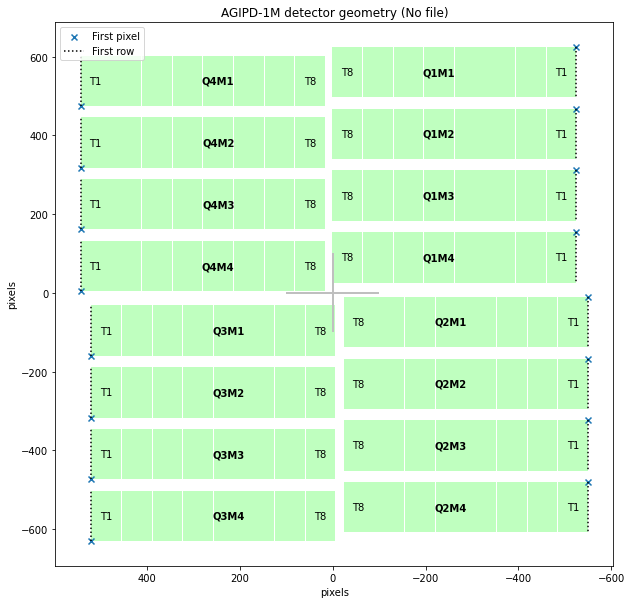

In [7]:
geom.inspect()

In [9]:
geom_file = 'agipd_simple_2d.geom'
geom.write_crystfel_geom(
    geom_file,
    dims=('frame', 'ss', 'fs'),
    adu_per_ev=1.0,
    clen=0.13,          # Sample - detector distance in m
    photon_energy=4972, # eV
    data_path='/data/data',
)

## Diffractor Settings

In [10]:
diffParam = CrystFELPhotonDiffractorParameters(
    sample='3WUL.pdb',                    # Looks up pdb file in cwd, if not found, queries from RCSB pdb mirror.
    uniform_rotation=True,                # Apply random rotation
    number_of_diffraction_patterns=2,     #
    powder=False,                         # Set xto True to create a virtual powder diffraction pattern (unested)
    intensities_file=None,                # File that contains reflection intensities. If set to none, use uniform intensity distribution
    crystal_size_range=[1e-7, 1e-7],      # Range ([min,max]) in units of metres of crystal size.
    poissonize=False,                     # Set to True to add Poisson noise.
    number_of_background_photons=0,       # Change number to add uniformly distributed background photons.
    suppress_fringes=False,               # Set to True to suppress side maxima between reflection peaks.
    beam_parameters=beamParam,            # Beam parameters object from above
    detector_geometry=geom_file,          # External file that contains the detector geometry in CrystFEL notation.
)

PDB file 3WUL.pdb could not be found. Attempting to query from protein database server.


In [11]:
diffractor = CrystFELPhotonDiffractor(
    parameters=diffParam, output_path=data_path
)

## Run the simulation

In [14]:
diffractor.backengine()

In [14]:
diffractor.saveH5()

Renaming diffr_out-1.h5 to diffr_out_0000001.h5.
Renaming diffr_out-2.h5 to diffr_out_0000002.h5.
Linking all patterns into /gpfs/exfel/data/user/juncheng/M5.2DEMO/simex/diffr.h5.


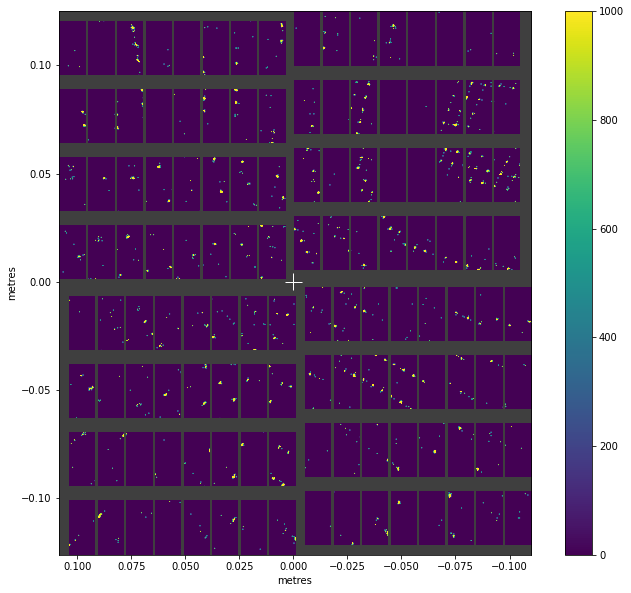

In [17]:
data_f = h5py.File(data_path + '.h5', 'r')
frame = data_f['data/0000001/data'][...].reshape(16, 512, 128)

fig, ax = plt.subplots(figsize=(12, 10))
geom.plot_data_fast(frame, axis_units='m', ax=ax, vmax=1000);

This project has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No. 823852.